In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
from statistics import mean

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Dataset TA/BRI/BBRI M

Mounted at /content/drive
/content/drive/MyDrive/Dataset TA/BRI/BBRI M


In [ ]:
data = pd.read_csv('BBRI M.csv')
data

,Tanggal,Laba Rugi
0,January 2011,910348
1,February 2011,1818894
2,March 2011,2932219
3,April 2011,4353052
4,May 2011,5433392
...,...,...
127,August 2021,15846192
128,September 2021,16775708
129,October 2021,21554902
130,November 2021,25089983


# Preprocessing

In [ ]:
def transform(data):
  j = 0
  k = j + 11
  while k <= len(data):
    l = k
    while l != j :
      a = data["Laba Rugi"][l] - data["Laba Rugi"][l-1]
      data["Laba Rugi"][l] = a
      l -= 1
    j = k + 1
    k = j + 11
    
  return data

data = transform(data)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tanggal,Laba Rugi
0,January 2011,910348
1,February 2011,908546
2,March 2011,1113325
3,April 2011,1420833
4,May 2011,1080340
...,...,...
127,August 2021,3867110
128,September 2021,929516
129,October 2021,4779194
130,November 2021,3535081


In [ ]:
# data.to_excel('transformed data BBRI M.xlsx')

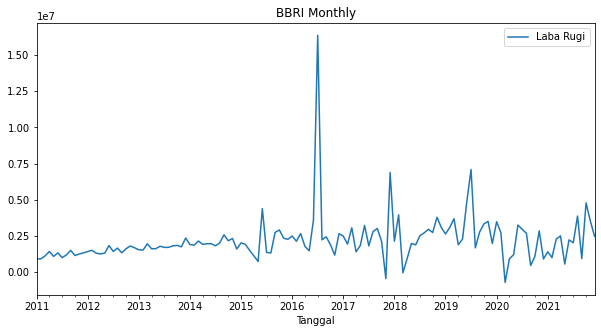

In [ ]:
data.index = pd.to_datetime(data.Tanggal)
data.drop(["Tanggal"], axis=1, inplace=True)
data.plot(title="BBRI Monthly", figsize=(10,5))

In [ ]:
scaler = MinMaxScaler()

data[['Laba Rugi']] = scaler.fit_transform(data[['Laba Rugi']])
data

,Laba Rugi
Tanggal,
2011-01-01,0.095472
2011-02-01,0.095366
2011-03-01,0.107356
2011-04-01,0.125360
2011-05-01,0.105425
...,...
2021-08-01,0.268584
2021-09-01,0.096594
2021-10-01,0.321984


In [ ]:
#Train : Test -> 75 : 25
split = int(round(len(data)*.75,0))
data_train = data[:split] #time series as train data (75%)
data_test = data[split:] #time series as test data (25%)

#Train : Test -> 50 : 50
# split = int(round(len(data)*.5,0))
# data_train = data[:split] #time series as train data (50%)
# data_test = data[split:] #time series as test data (50%)


data_train_arr = data_train.to_numpy()
data_test_arr = data_test.to_numpy()

train = np.reshape(data_train_arr, (data_train_arr.shape[0]))
test = np.reshape(data_test_arr, (data_test_arr.shape[0]))

In [ ]:
print("% data test: ", len(data_test)/132*100)

% data test:  25.0


In [ ]:
#input sampling timeseries
n_sampling = 12

def split_sequence(sequence, n_steps):
	_X, _y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		_X.append(seq_x)
		_y.append(seq_y)
	return np.array(_X), np.array(_y)

x_train, y_train = split_sequence(train, n_sampling)
x_test, y_test = split_sequence(test, n_sampling)

# Learning Rate

In [ ]:
learning_rate = 0
j = 1
lr_history = []
for i in range (6):
  while j >= 1:
    n = n_sampling
    input = n + 1
    layer1 = input
    output = 1
    tf.random.set_seed(100)
    #Ultilize Learning Rate
    learning_rate = round(j * 10**-i,6)
    epoch = 100
    
    #define Optimizer
    adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    # define model
    model1 = Sequential()
    model1.add(Dense(input, activation='relu', input_dim=n))
    model1.add(Dense(layer1, activation='relu'))
    model1.add(Dense(output, activation='linear'))
    model1.compile(optimizer=adam, loss='mse')

    # fit model
    history = model1.fit(x_train, y_train, epochs=epoch, verbose=0)

    #Collect Average Loss History
    loss = history.history["loss"]
    loss = mean(loss)

    #Calculate MSE for training
    train_pred = model1.predict(x_train, verbose=0)
    msetrain = mean_squared_error(y_train, train_pred)

    #Calculate MSE for testing
    test_pred = model1.predict(x_test, verbose=0)
    msetest = mean_squared_error(y_test, test_pred)

    #Store loss value into list
    lr_history.append([learning_rate,loss,msetrain,msetest])

    j -= 1
  j = 9
    

In [ ]:
# lr_history_model_inverted = scaler.inverse_transform(lr_history)
# lr_history_model_inverted = pd.DataFrame(lr_history_model_inverted, columns = ['Learning Rate', 'Average Loss', 'MSE Train', 'MSE Test'])
# lr_history_model = pd.DataFrame(lr_history, columns = ['Learning Rate', 'Average Loss', 'MSE Train', 'MSE Test'])
# lr_history_model_inverted

In [ ]:
lr_history_model = pd.DataFrame(lr_history, columns = ['Learning Rate', 'Average Loss', 'MSE Train', 'MSE Test'])

#file name excel
file_name = 'learning rate history v3 n_sampling=12 75 25 inverted.xlsx'

#saving to excel
lr_history_model_inverted.to_excel(file_name)
print("DataFrame is written to Excel File successfully")

# data_history_model

DataFrame is written to Excel File successfully


In [ ]:
#The best Learning Rate for 75:25 is 0.007
#The best Learning Rate for 50:50 is 0.008

# Epoch

In [ ]:
epoch_history = []
for i in range(1000):
  #define param
  n = n_sampling
  input = n + 1
  layer1 = input
  output = 1
  learning_rate = 0.007
  epoch = i+1
  tf.random.set_seed(100)

  #define Optimizer
  adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

  # define model
  model2 = Sequential()
  model2.add(Dense(input, activation='relu', input_dim=n))
  model2.add(Dense(layer1, activation='relu'))
  model2.add(Dense(output, activation='linear'))
  model2.compile(optimizer=adam, loss='mse')

  # fit model 
  history = model2.fit(x_train, y_train, epochs=epoch, verbose=0)

  #Collect Average Loss History
  loss = history.history["loss"]
  loss = mean(loss)

  #Calculate MSE for training
  train_pred = model2.predict(x_train, verbose=0)
  msetrain = mean_squared_error(y_train, train_pred)

  #Calculate MSE for testing
  test_pred = model2.predict(x_test, verbose=0)
  msetest = mean_squared_error(y_test, test_pred)

  #Store loss value into list
  epoch_history.append([epoch,loss,msetrain,msetest])


In [ ]:
# epoch_history_model = pd.DataFrame(epoch_history, columns = ['Epoch', 'Average Loss', 'MSE Train', 'MSE Test'])

# #file name excel
# file_name = 'epoch history v3 n_sampling=12.xlsx'

# #saving to excel
# epoch_history_model.to_excel(file_name)
# print("DataFrame is written to Excel File successfully")

# # data_history_model

DataFrame is written to Excel File successfully


In [ ]:
#epoch for 75:25 is 90

# 1 Hidden Layer

In [ ]:
layer1_history = []
for i in range(500):
  #define param
  n = n_sampling
  input = n + 1
  layer1 = i+1
  output = 1
  learning_rate = 0.007
  epoch = 90
  tf.random.set_seed(100)

  #define Optimizer
  adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

  # define model
  model3 = Sequential()
  model3.add(Dense(input, activation='relu', input_dim=n))
  model3.add(Dense(layer1, activation='relu'))
  model3.add(Dense(output, activation='linear'))
  model3.compile(optimizer=adam, loss='mse')

  # fit model 
  history = model3.fit(x_train, y_train, epochs=epoch, verbose=0)

  #Calculate Average Loss
  loss = history.history["loss"]
  loss = mean(loss)

  #Calculate MSE for training
  train_pred = model3.predict(x_train, verbose=0)
  msetrain = mean_squared_error(y_train, train_pred)

  #Calculate MSE for Testing
  test_pred = model3.predict(x_test, verbose=0)
  msetest = mean_squared_error(y_test, test_pred)

  layer1_history.append([layer1,loss,msetrain,msetest])

In [ ]:
# layer1_history_model = pd.DataFrame(layer1_history, columns = ['Layer 1', 'Average Loss', 'MSE Train', 'MSE Test'])

# #file name excel
# file_name = 'layer 1 history V3 n_sampling=12 50-50.xlsx'

# #saving to excel
# layer1_history_model.to_excel(file_name)
# print("DataFrame is written to Excel File successfully")

# # data_history_model

DataFrame is written to Excel File successfully


In [ ]:
#Layer 1 for 75 50 is 13

# 2 Hidden Layer

In [ ]:
layer2_history = []
for i in range(500):
  #define param
  n = n_sampling
  input = n + 1
  layer1 = 13
  layer2 = i+1
  output = 1
  learning_rate = 0.007
  epoch = 90
  tf.random.set_seed(100)

  #define Optimizer
  adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

  # define model
  model4 = Sequential()
  model4.add(Dense(input, activation='relu', input_dim=n))
  model4.add(Dense(layer1, activation='relu'))
  model4.add(Dense(layer2, activation='relu'))
  model4.add(Dense(output, activation='linear'))
  model4.compile(optimizer=adam, loss='mse')

  # fit model 
  history = model4.fit(x_train, y_train, epochs=epoch, verbose=0)

  #Calculate Average Loss
  loss = history.history["loss"]
  loss = mean(loss)

  #Calculate MSE for training
  train_pred = model4.predict(x_train, verbose=0)
  msetrain = mean_squared_error(y_train, train_pred)

  #Calculate MSE for Testing
  test_pred = model4.predict(x_test, verbose=0)
  msetest = mean_squared_error(y_test, test_pred)

  layer2_history.append([layer2,loss,msetrain,msetest])

In [ ]:
# layer2_history_model = pd.DataFrame(layer2_history, columns = ['layer 2', 'average loss', 'MSE Train', 'MSE Test'])

# #file name excel
# file_name = 'layer 2 history v3 n_sampling=12 50-50.xlsx'

# #saving to excel
# layer2_history_model.to_excel(file_name)
# print("DataFrame is written to Excel File successfully")

# # data_history_model

DataFrame is written to Excel File successfully


In [ ]:
#Layer 2 for 75 50 is none

# Combined

Training

In [ ]:
#define param
n = n_sampling
input = n + 1
layer1 = 13
# layer2 = 39
output = 1
learning_rate = 0.007
epoch = 90

tf.random.set_seed(100)

#define Optimizer
adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

# define model
model5 = Sequential()
model5.add(Dense(input, activation='relu', input_dim=n))
model5.add(Dense(layer1, activation='relu'))
# model5.add(Dense(layer2, activation='relu'))
model5.add(Dense(output, activation='linear'))
model5.compile(optimizer=adam, loss='mse')

# fit model 
history = model5.fit(x_train, y_train, epochs=epoch, verbose=0)

In [ ]:
#alasan pilih parameter tersebut adalah mencari yang paling seimbang antara loss, volatilitas pada seluruh data, dan simplicity

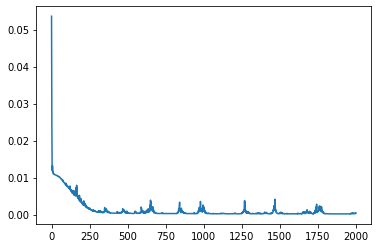

In [ ]:
plt.plot(history.history['loss'])

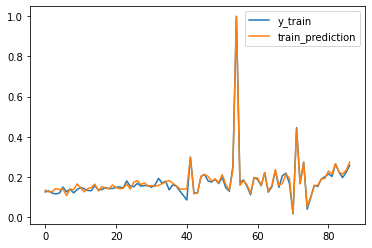

In [ ]:
# plot train model
train_prediction = model5.predict(x_train, verbose=0)

train_prediction = np.reshape(train_prediction, (train_prediction.shape[0]))

Tanggal = data[:split].index.to_numpy()
Tanggal = Tanggal[n_sampling:]

#Plot test and prediction model
y_PD =  pd.DataFrame(data={'Tanggal':Tanggal, 'y_train':y_train},   
              index=Tanggal,    
              columns=['Tanggal', 'y_train'])  

train_prediction_PD = pd.DataFrame(data={'Tanggal':Tanggal, 'train_prediction':train_prediction},   
              index=Tanggal,    
              columns=['Tanggal', 'train_prediction']) 

Final_PD = pd.merge(y_PD, train_prediction_PD, on='Tanggal', how='left')

Final_PD[['y_train','train_prediction']].plot()

In [ ]:
# Final_PD.index = pd.to_datetime(Final_PD.Tanggal)
# Final_PD.drop(["Tanggal"], axis=1, inplace=True)

# Final_PD_inv = scaler.inverse_transform(Final_PD)
# Final_PD_model = pd.DataFrame(Final_PD_inv, columns = ['y_train','train_prediction'])

# Final_PD_model.to_excel('Training Result v3 n_sampling=12.xlsx')

In [ ]:
y_PD.drop(["Tanggal"], axis=1, inplace=True)
train_prediction_PD.drop(["Tanggal"], axis=1, inplace=True)

y_PD_arr = y_PD.to_numpy()
y_prediction_PD_arr = train_prediction_PD.to_numpy()

In [ ]:
mse = mean_squared_error(y_PD_arr, y_prediction_PD_arr)
print("Akurasi", (1-mse))
print("MSE: ", mse)

Akurasi 0.9997861636327366
MSE:  0.00021383636726334524


In [ ]:
#Train 75 25 MSE=0.008317363447995996

Testing

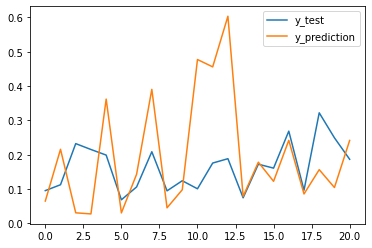

In [ ]:
# test model
y_prediction = model5.predict(x_test, verbose=0)

y_prediction = np.reshape(y_prediction, (y_prediction.shape[0]))

Tanggal = data[split:].index.to_numpy()
Tanggal = Tanggal[n_sampling:]

#Plot test and prediction model
y_PD =  pd.DataFrame(data={'Tanggal':Tanggal, 'y_test':y_test},   
              index=Tanggal,    
              columns=['Tanggal', 'y_test'])  

y_prediction_PD = pd.DataFrame(data={'Tanggal':Tanggal, 'y_prediction':y_prediction},   
              index=Tanggal,    
              columns=['Tanggal', 'y_prediction']) 

Final_PD = pd.merge(y_PD, y_prediction_PD, on='Tanggal', how='left')

Final_PD[['y_test','y_prediction']].plot()

In [ ]:
# Final_PD.index = pd.to_datetime(Final_PD.Tanggal)
# Final_PD.drop(["Tanggal"], axis=1, inplace=True)

# Final_PD_inv = scaler.inverse_transform(Final_PD)
# Final_PD_model = pd.DataFrame(Final_PD_inv, columns = ['y_test','y_prediction'])

# Final_PD_model.to_excel('Prediction Result v3 n_sampling=12.xlsx')

Mean Square Error

In [ ]:
y_PD.drop(["Tanggal"], axis=1, inplace=True)
y_prediction_PD.drop(["Tanggal"], axis=1, inplace=True)

y_PD_arr = y_PD.to_numpy()
y_prediction_PD_arr = y_prediction_PD.to_numpy()

In [ ]:
mse = mean_squared_error(y_PD_arr, y_prediction_PD_arr)
print("Akurasi", (1-mse))
print("MSE: ", mse)

Akurasi 0.9714778054598179
MSE:  0.02852219454018217


In [ ]:
#Test 75 25 MSE=0.004293925384576116

Export Final Model

In [ ]:
# #Saving Model
# model5.save('BBRI M V3 13 0.007 90 mse=0.004294')

# #Load Model
# # model = keras.models.load_model('path/to/location')

INFO:tensorflow:Assets written to: BBRI M 60 0.005 50 mse=0.004772/assets


In [ ]:
# #export model using pickel
# import pickle

# #save model to disk
# filename = 'BBRI M V3 7 0.008 114 mse=0.00792 50 50.sav'
# pickle.dump(model5, open(filename, 'wb'))

# # load the model from disk
# # loaded_model = pickle.load(open(filename, 'rb'))
# # result = loaded_model.score(X_test, Y_test)
# # print(result)

INFO:tensorflow:Assets written to: ram://785fcc31-17e4-4bfc-a1df-e2560fb4f54f/assets


In [ ]:
# #export model using joblib
# import joblib

# # save the model to disk
# # filename = 'finalized_model.sav'
# # joblib.dump(model, filename)

# # load the model from disk
# model_name = 'BBRI M 8 0.008 161 loss=0.00609.sav'
# loaded_model = joblib.load(model_name)
# # result = loaded_model.predict(x_test, y_test)
# # print(result)

In [ ]:
# loaded_model.weights

[<tf.Variable 'dense_13/kernel:0' shape=(5, 6) dtype=float32, numpy=
 array([[ 0.4728928 , -0.20804167, -0.8398208 , -0.6216376 ,  0.24435224,
          0.18924084],
        [ 0.1258476 , -0.82959116, -0.26968738, -0.5856874 ,  1.1913812 ,
         -0.5835206 ],
        [ 0.23100875, -0.22577332,  0.80493826,  0.0448702 , -0.10766881,
          0.72420526],
        [ 0.37208772,  0.36150286,  0.10642855, -0.5134552 ,  0.21437846,
         -0.09376506],
        [ 0.6509784 , -0.6006384 , -0.47103286, -0.35389954,  0.3349238 ,
          0.4597595 ]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(6,) dtype=float32, numpy=
 array([-0.03140027, -0.10985053, -0.1374046 ,  0.        , -0.09625794,
         0.07550149], dtype=float32)>,
 <tf.Variable 'dense_14/kernel:0' shape=(6, 8) dtype=float32, numpy=
 array([[-0.13460448,  0.21763717,  0.7874137 , -0.2642669 , -0.66650474,
         -0.41222557,  0.4523649 ,  0.19247651],
        [ 0.21431172, -0.05113324,  0.46321395,  0.03421104